# Experiment 5: PCA for elevation, u and v

In this experiment we will combine the surface elevation, u and v components of the water currents into a single dataset and perform PCA on it.

### Imports:

In [1]:
# Import packages:
import mikeio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys
import pandas as pd 
import seaborn as sns
import pickle as pkl


sys.path.append("../")
plt.style.use("seaborn-v0_8-whitegrid")

from Scripts import my_functions as mf

from mikeio.eum import EUMUnit
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from IPython.display import HTML
from tqdm import tqdm

### Data Extraction

In [2]:
## Find the relative path to Data/DHI_wk_sim/Area.dfsu from current directory:

# Go up two levels from current directory:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Overwrite path:
path = os.path.join(path, "Data/DHI_yr_sim/Area.dfsu")

# Open dfsu file:
mikeio.open(path)

Dfsu2D
number of elements: 17980
number of nodes: 10460
projection: LONG/LAT
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)
time: 18191 steps with dt=1800.0s
      1996-12-18 00:00:00 -- 1997-12-31 23:00:00

In [3]:
# Get first and last time step:
time = mikeio.open(path).time
print("\n", time[0], "\n", time[-1])


 1996-12-18 00:00:00 
 1997-12-31 23:00:00


In [4]:
# Find time index:
train_id_start, train_id_stop = \
    time.get_indexer(["1997-01-01", "1997-07-01"])


In [5]:
# Choose sample size: (3 months)
n_samples = 48*7*4*3

# 3-month-sized systematic sample:
sample_ids = np.linspace(train_id_start, train_id_stop, n_samples, dtype=int)

In [6]:
print("Train IDs: ", train_id_start, train_id_stop)
print("Sample IDs: ", min(sample_ids), max(sample_ids))

Train IDs:  672 9360
Sample IDs:  672 9360


## Data split: (6 months training data. 6 months test data.)

In [7]:
# Load data (~ 2 min):
data_fit = mikeio.read(
    path,
    items=[0,2,3],
    time=sample_ids.tolist(),
    )

In [8]:
# Extract data and values:
z_data_fit = data_fit[0];   z_vals_fit = z_data_fit.values
u_data_fit = data_fit[1];   u_vals_fit = u_data_fit.values
v_data_fit = data_fit[2];   v_vals_fit = v_data_fit.values

# Combine data:
pca_fit_data = np.concatenate((z_vals_fit, u_vals_fit, v_vals_fit), axis=1)

### Models:

In [9]:
# Super class for models:
class myModels():
    
    def __init__(self):
        pass
    
    # Templates:
    class ModelTemplate:
        """
        Ensures that the methods fit, predict, and fit_predict are 
        instantiated for all classes based on this template.
        """

        def fit(self, X, y=None):
            raise NotImplementedError("fit method must be implemented in subclass")

        def predict(self, X):
            raise NotImplementedError("predict method must be implemented in subclass")

        def fit_predict(self, X, y=None):
            self.fit(X, y)
            return self.predict(X)
        
    class IPCA(ModelTemplate):

        def __init__(self, n_components=None):
            self.n_components = n_components
            self.model = IncrementalPCA(n_components=self.n_components,
                                        batch_size=self.n_components)

        def fit(self, X, y=None):
            self.model.fit(X, y)
            return self

        def predict(self, X):
            X = self.model.transform(X)
            return self.model.inverse_transform(X)
        
    class PCA(ModelTemplate):
        
        def __init__(self, n_components=None):
            self.n_components = n_components
            self.model = PCA(n_components=self.n_components)

        def fit(self, X, y=None):
            self.model.fit(X, y)
            return self

        def predict(self, X):
            X = self.model.transform(X)
            return self.model.inverse_transform(X)

In [11]:
# Choose whether to load pre-fitted scaler and PCA:
if 1:
    
    # Load scaler and PCA:
    scaler = pkl.load(open("../Data_Results/Exp_5_scaler.pkl", "rb"))
    pca = pkl.load(open("../Data_Results/Exp_5_pca.pkl", "rb"))


In [12]:
# Choose whether to fit scaler and PCA:
if 0:

    # Instantiate PCA and scaler:
    scaler = StandardScaler()
    pca = myModels.IPCA(n_components=100)

    # Scale data:
    pca_fit_data_scaled = scaler.fit_transform(pca_fit_data)

    # Fit PCA:
    pca.fit(pca_fit_data_scaled)

In [13]:
# Save scalers and pcas (in Coding/Data_Results):
if 1:
    with open("../Data_Results/Exp_5_scaler.pkl", "wb") as f:
        pkl.dump(scaler, f)

    with open("../Data_Results/Exp_5_pca.pkl", "wb") as f:
        pkl.dump(pca, f)


### Explained variance

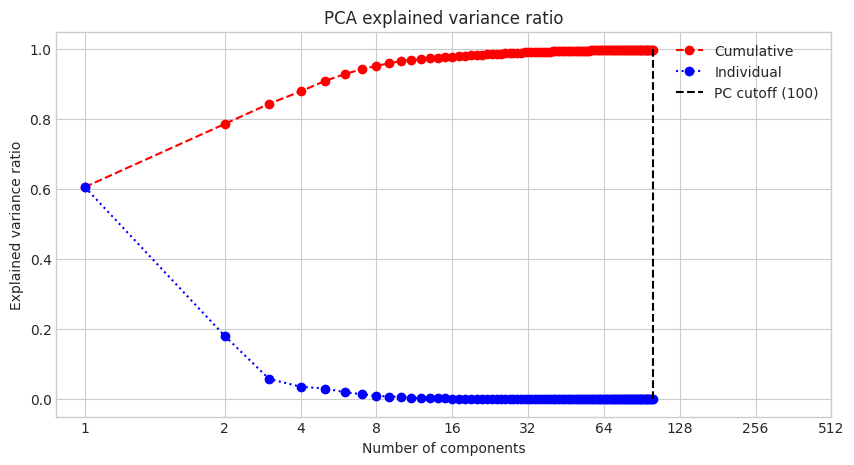

In [14]:
# Plot the PCA E.V.R:
fig1 = plt.figure(figsize=(10,5))
pca_x_ticks = np.arange(1, pca.model.n_components_+1, 1)
plt.plot(pca_x_ticks,
         np.cumsum(pca.model.explained_variance_ratio_),
         "o",
         linestyle="dashed",
         color="red")

plt.plot(pca_x_ticks,
         pca.model.explained_variance_ratio_,
         "o",
         linestyle="dotted",
         color="blue")

pc_keep = np.sum(pca.model.explained_variance_ > 1)

plt.vlines(pc_keep, 0, 1, colors="black", linestyles="dashed")

plt.legend(["Cumulative", "Individual", f"PC cutoff ({pc_keep})"])
plt.xscale("symlog")

plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")

pca_x_gridlines = np.array([2**i for i in range(10)])

plt.xticks(pca_x_gridlines,
           [str(pca_x_gridlines[i]) \
            for i in range(len(pca_x_gridlines))])

plt.title("PCA explained variance ratio")
plt.show()

In [18]:
pca.model.explained_variance_[-10:]

array([1.72407677, 1.64074694, 1.57744859, 1.48365535, 1.46322609,
       1.37070194, 1.32458603, 1.28775849, 1.24843204, 1.19243931])

In [45]:
# Save figure:
fig1.savefig("../Figures/Exp_5_Full_PCA_EVR.png", dpi=100)

### Visualization of principal components

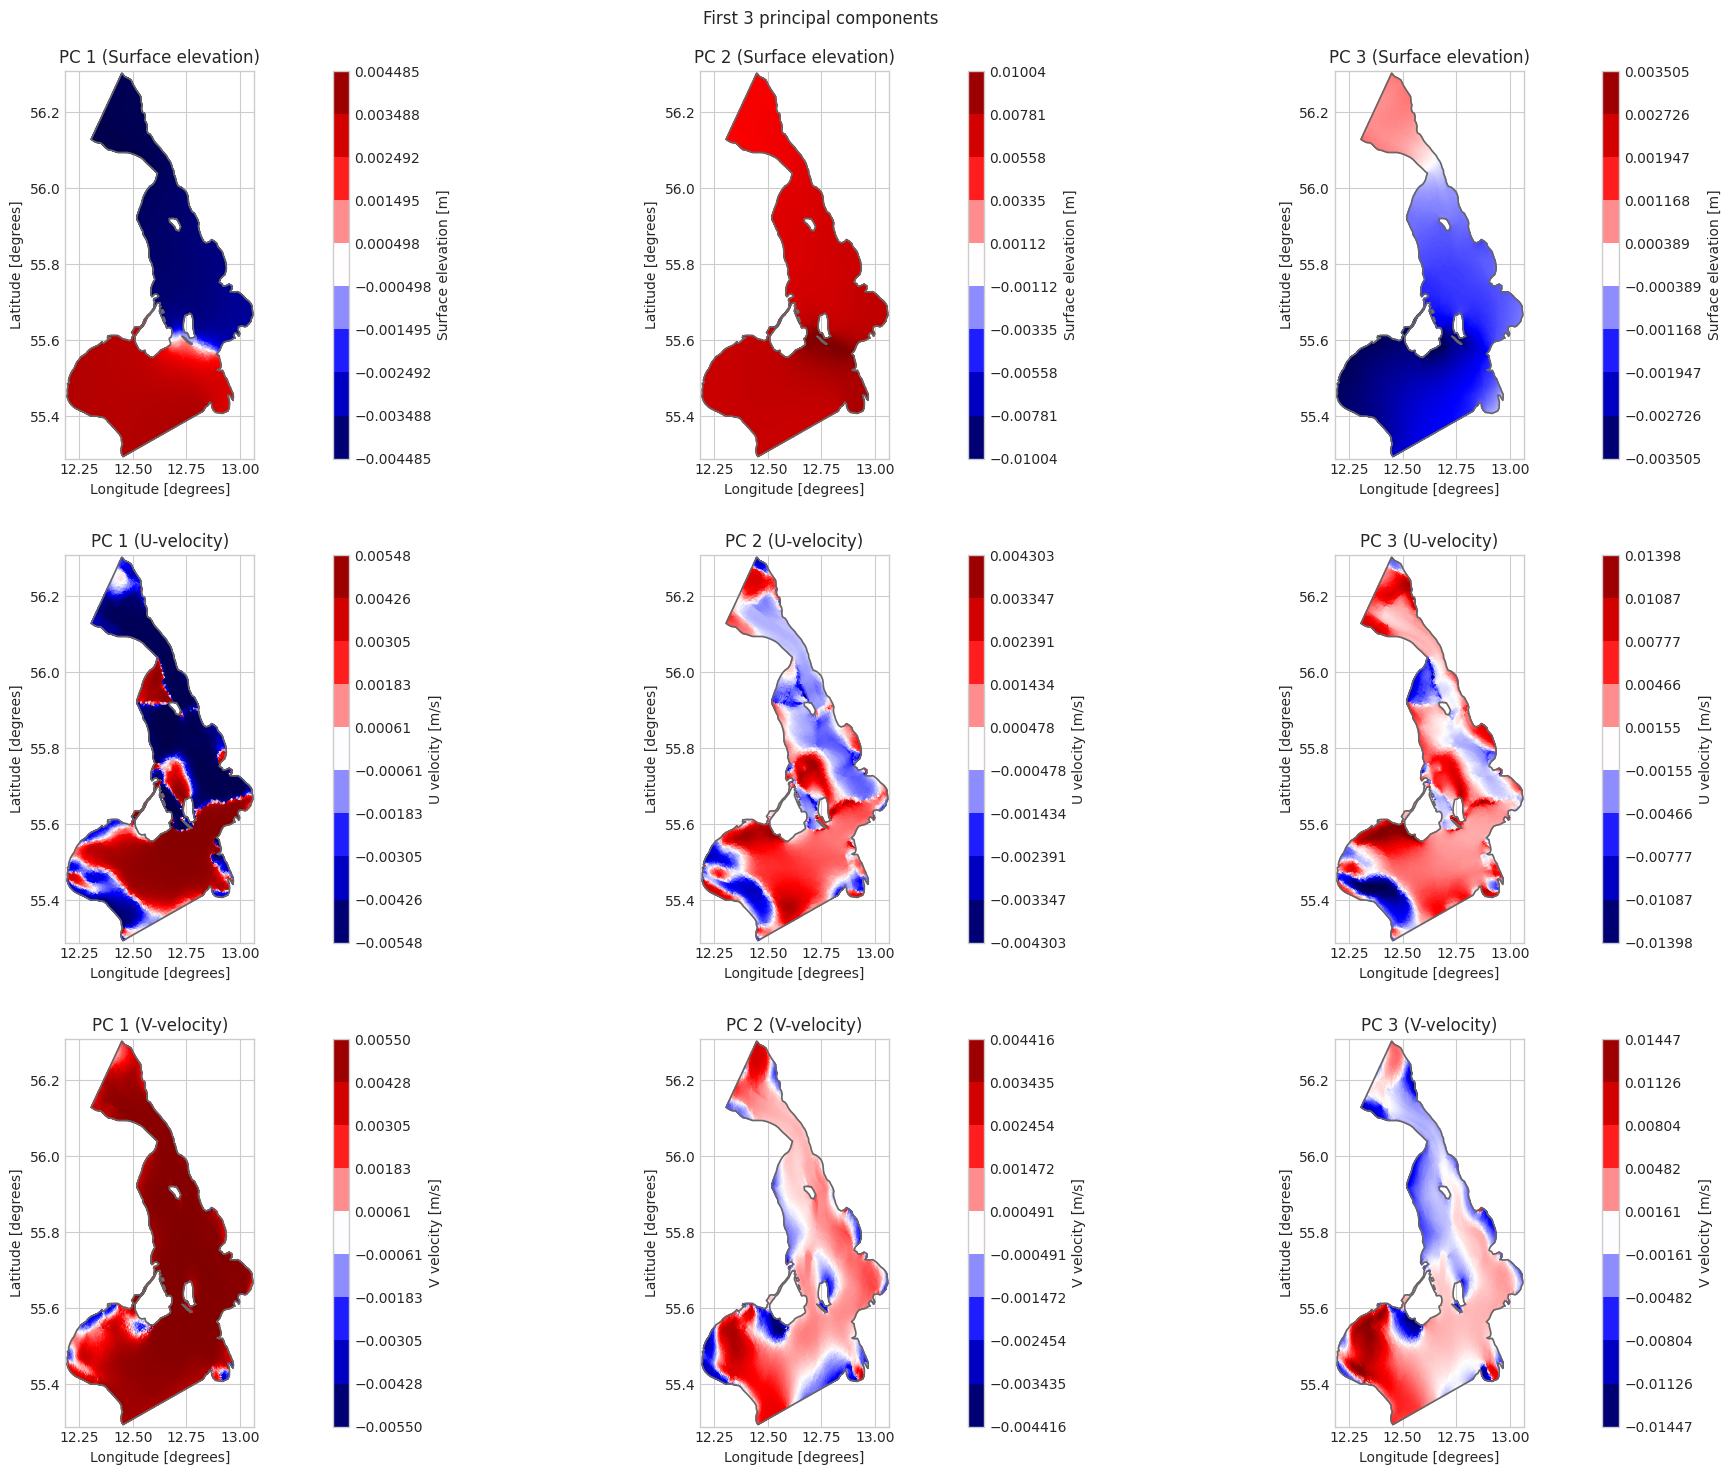

In [81]:
princomps = pca.model.components_

plot_obj_z = data_fit.Surface_elevation[0].copy()
plot_obj_u = data_fit.U_velocity[0].copy()
plot_obj_v = data_fit.V_velocity[0].copy()

# Plot the first 3 principal components (3 by 3 subplot):
fig2, axs = plt.subplots(3, 3, figsize=(20,15))

n_feats = data_fit.shape[1]

for i in range(3):
    plot_obj_z.values = princomps[i, :n_feats]
    plot_obj_u.values = princomps[i, n_feats:2*n_feats]
    plot_obj_v.values = princomps[i, 2*n_feats:]

    plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
    plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
    plot_obj_v_max = np.max(np.abs(plot_obj_v.values))


    plot_obj_z.plot(ax=axs[0,i], cmap="seismic",
                    vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
    plot_obj_u.plot(ax=axs[1,i], cmap="seismic",
                    vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
    plot_obj_v.plot(ax=axs[2,i], cmap="seismic",
                    vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

    # Set titles (Surface elevation, U-velocity, V-velocity):
    axs[0,i].set_title("\nPC {}".format(i+1) + " (Surface elevation)")
    axs[1,i].set_title("\nPC {}".format(i+1) + " (U-velocity)")
    axs[2,i].set_title("\nPC {}".format(i+1) + " (V-velocity)")

fig2.suptitle("First 3 principal components")

plt.tight_layout()
plt.show()

In [82]:
# Save figure:
fig2.savefig("../Figures/Exp_5_1-3pc.png", dpi=100)


### Reconstruction differences

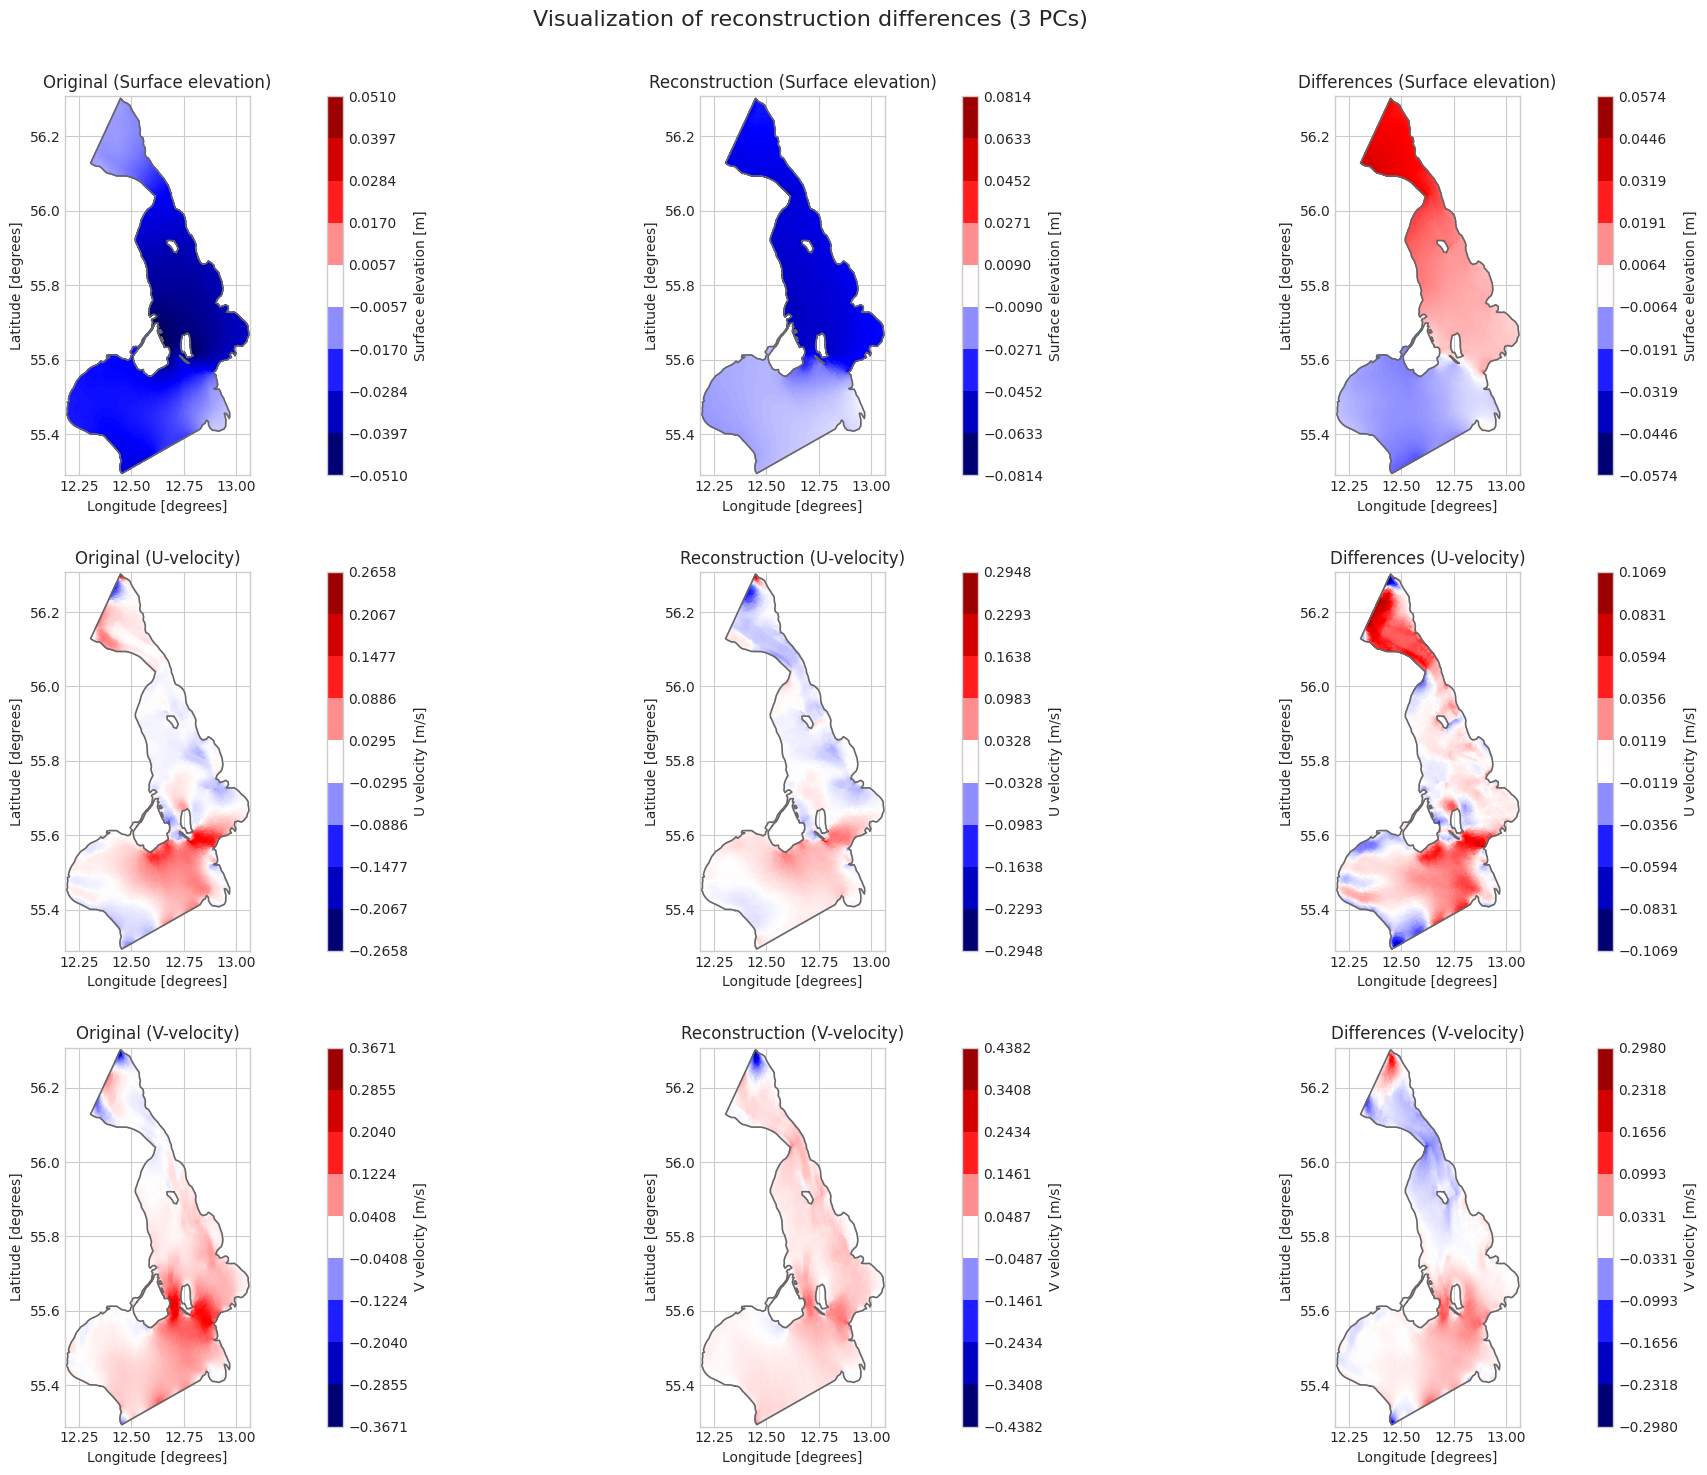

In [67]:
# Manual PCA projection:
# ----------------------

# Choose number of components:
n_comps = 3

# Project onto first n_comps:
pca_fit_data_scaled_proj = np.dot(pca_fit_data_scaled[-1], 
                                  princomps[:n_comps].T)

# Reconstruct:
pca_fit_data_scaled_recon = np.dot(pca_fit_data_scaled_proj, 
                                   princomps[:n_comps])

# Rescale:
pca_fit_data_recon = scaler.inverse_transform(
                        pca_fit_data_scaled_recon.reshape(1,-1)).flatten()

# Plot (Original, reconstruction and differences):
fig3, axs = plt.subplots(3, 3, figsize=(20,15))

# Original:
plot_obj_z.values = pca_fit_data[-1, :n_feats]
plot_obj_u.values = pca_fit_data[-1, n_feats:2*n_feats]
plot_obj_v.values = pca_fit_data[-1, 2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,0], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,0], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,0], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,0].set_title("\nOriginal" + " (Surface elevation)")
axs[1,0].set_title("\nOriginal" + " (U-velocity)")
axs[2,0].set_title("\nOriginal" + " (V-velocity)")

# Reconstruction:
plot_obj_z.values = pca_fit_data_recon[:n_feats]
plot_obj_u.values = pca_fit_data_recon[n_feats:2*n_feats]
plot_obj_v.values = pca_fit_data_recon[2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,1], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,1], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,1], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,1].set_title("\nReconstruction" + " (Surface elevation)")
axs[1,1].set_title("\nReconstruction" + " (U-velocity)")
axs[2,1].set_title("\nReconstruction" + " (V-velocity)")

# Differences:
pca_fit_diff = pca_fit_data[-1] - pca_fit_data_recon

plot_obj_z.values = pca_fit_diff[:n_feats]
plot_obj_u.values = pca_fit_diff[n_feats:2*n_feats]
plot_obj_v.values = pca_fit_diff[2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,2], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,2], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,2], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,2].set_title("\nDifferences" + " (Surface elevation)")
axs[1,2].set_title("\nDifferences" + " (U-velocity)")
axs[2,2].set_title("\nDifferences" + " (V-velocity)")

fig3.suptitle(f"Visualization of reconstruction differences ({n_comps} PCs)\n",
              fontsize=16)

plt.tight_layout()
plt.show()


In [92]:
# Save figure:
fig3.savefig("../Figures/Exp_5_full_PCA_3PC_comparison.png", dpi=100)

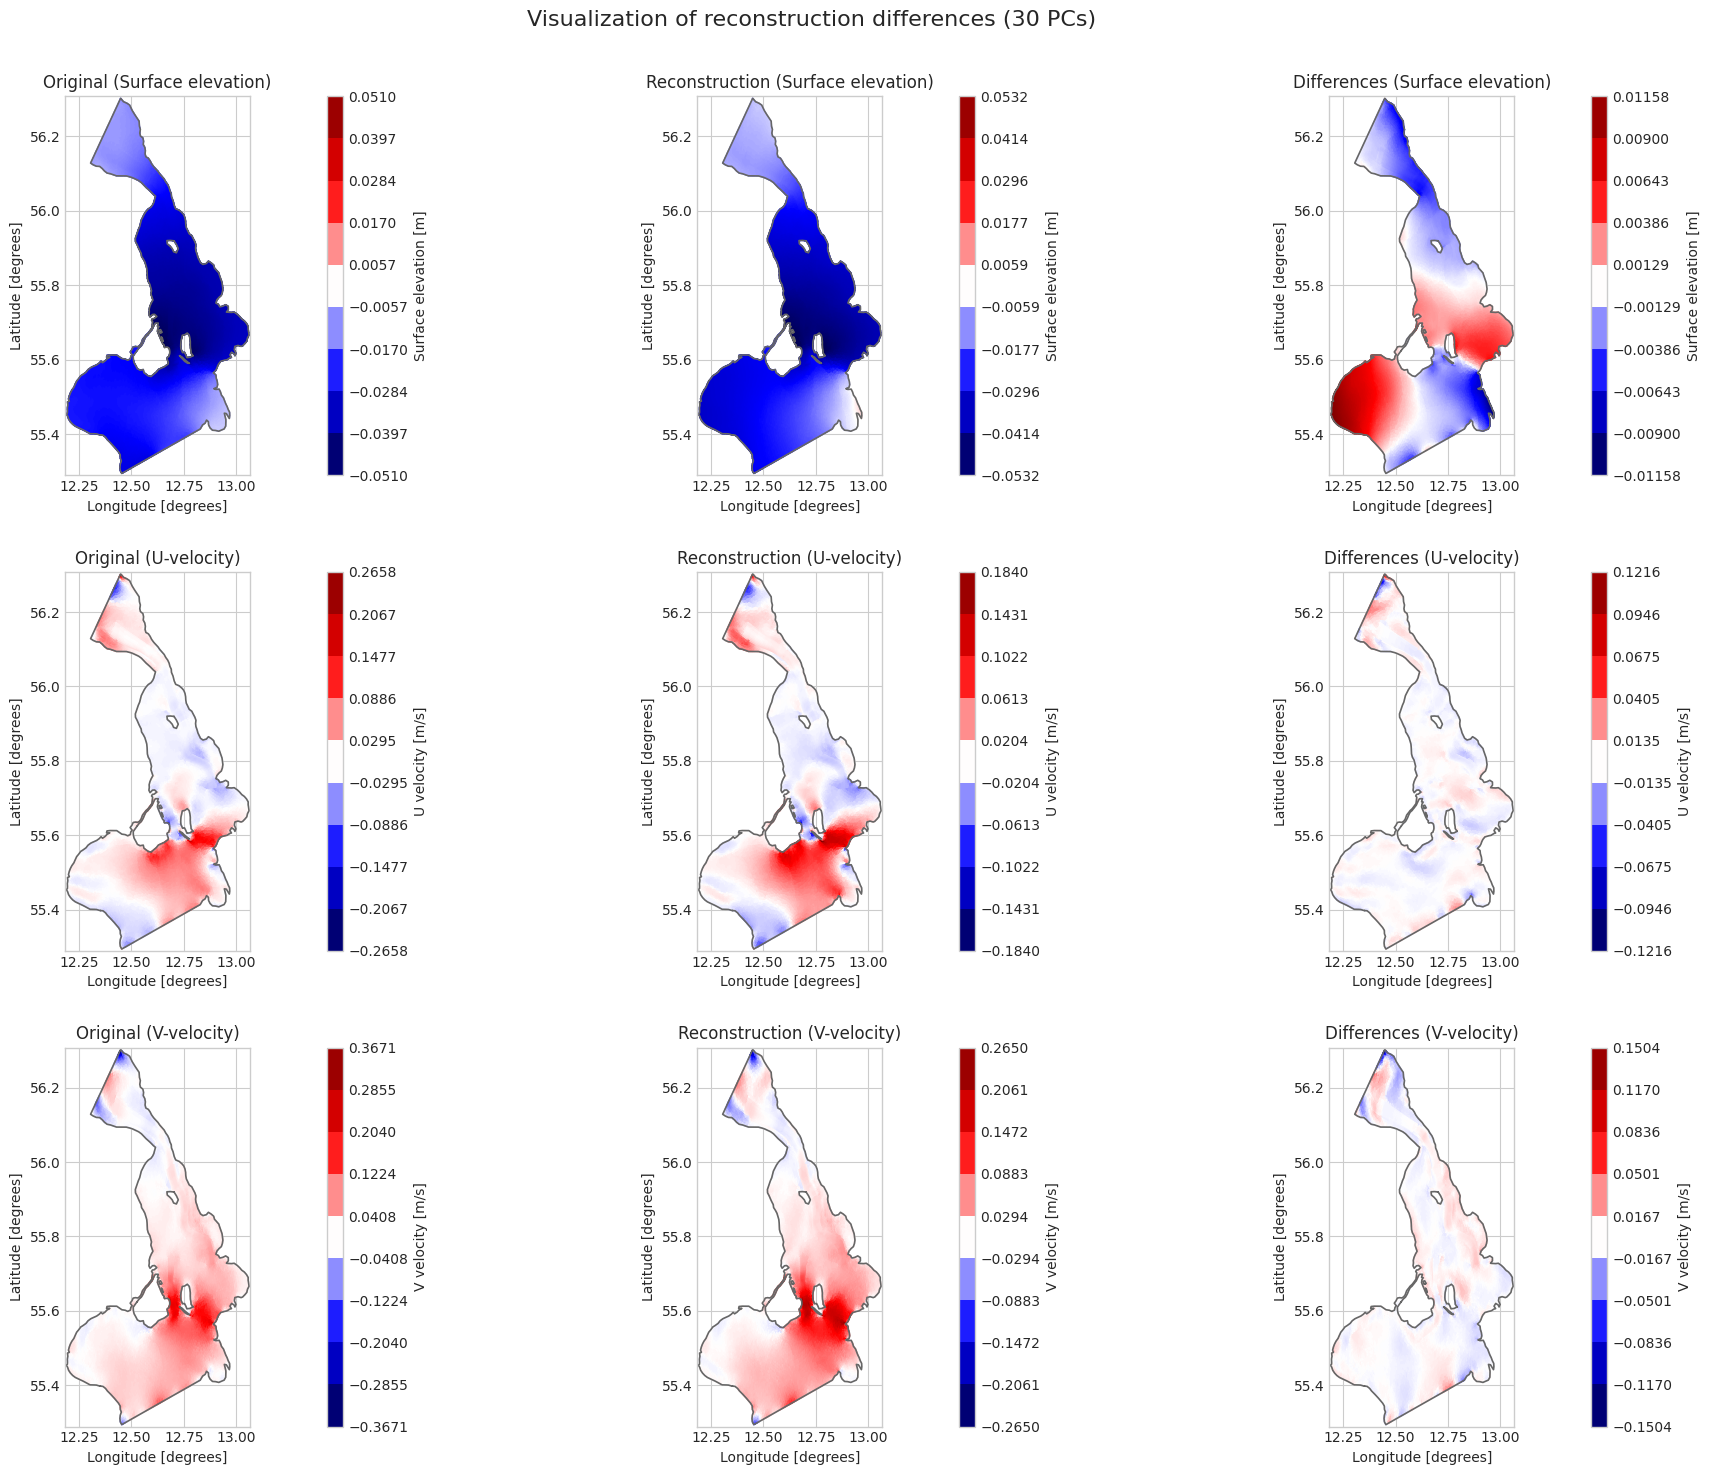

In [93]:
# Manual PCA projection:
# ----------------------

# Choose number of components:
n_comps = np.argwhere(np.cumsum(pca.model.explained_variance_ratio_) > 0.99)[0,0]

# Project onto first n_comps:
pca_fit_data_scaled_proj = np.dot(pca_fit_data_scaled[-1], 
                                  princomps[:n_comps].T)

# Reconstruct:
pca_fit_data_scaled_recon = np.dot(pca_fit_data_scaled_proj, 
                                   princomps[:n_comps])

# Rescale:
pca_fit_data_recon = scaler.inverse_transform(
                        pca_fit_data_scaled_recon.reshape(1,-1)).flatten()

# Plot (Original, reconstruction and differences):
fig4, axs = plt.subplots(3, 3, figsize=(20,15))

# Original:
plot_obj_z.values = pca_fit_data[-1, :n_feats]
plot_obj_u.values = pca_fit_data[-1, n_feats:2*n_feats]
plot_obj_v.values = pca_fit_data[-1, 2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,0], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,0], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,0], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,0].set_title("\nOriginal" + " (Surface elevation)")
axs[1,0].set_title("\nOriginal" + " (U-velocity)")
axs[2,0].set_title("\nOriginal" + " (V-velocity)")

# Reconstruction:
plot_obj_z.values = pca_fit_data_recon[:n_feats]
plot_obj_u.values = pca_fit_data_recon[n_feats:2*n_feats]
plot_obj_v.values = pca_fit_data_recon[2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,1], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,1], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,1], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,1].set_title("\nReconstruction" + " (Surface elevation)")
axs[1,1].set_title("\nReconstruction" + " (U-velocity)")
axs[2,1].set_title("\nReconstruction" + " (V-velocity)")

# Differences:
pca_fit_diff = pca_fit_data[-1] - pca_fit_data_recon

plot_obj_z.values = pca_fit_diff[:n_feats]
plot_obj_u.values = pca_fit_diff[n_feats:2*n_feats]
plot_obj_v.values = pca_fit_diff[2*n_feats:]

plot_obj_z_max = np.max(np.abs(plot_obj_z.values))
plot_obj_u_max = np.max(np.abs(plot_obj_u.values))
plot_obj_v_max = np.max(np.abs(plot_obj_v.values))

plot_obj_z.plot(ax=axs[0,2], cmap="seismic",
                vmin=-plot_obj_z_max, vmax=plot_obj_z_max)
plot_obj_u.plot(ax=axs[1,2], cmap="seismic",
                vmin=-plot_obj_u_max, vmax=plot_obj_u_max)
plot_obj_v.plot(ax=axs[2,2], cmap="seismic",
                vmin=-plot_obj_v_max, vmax=plot_obj_v_max)

# Set titles (Surface elevation, U-velocity, V-velocity):
axs[0,2].set_title("\nDifferences" + " (Surface elevation)")
axs[1,2].set_title("\nDifferences" + " (U-velocity)")
axs[2,2].set_title("\nDifferences" + " (V-velocity)")

fig4.suptitle(f"Visualization of reconstruction differences ({n_comps} PCs)\n",
              fontsize=16)

plt.tight_layout()
plt.show()


In [95]:
# Save figure:
fig4.savefig("../Figures/Exp_5_full_PCA_30PC_comparison.png", dpi=100)

: 